##9.49 Final Project
Emergence of Grid Cells in Biological RNNs
Ashley Benallo and Jack King

In [165]:
from shapely.geometry import Polygon, Point
import random
import torch
import math
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import MSELoss
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [166]:
# Config
data_config = {
          "time_steps": 500,
          "step_size": 0.1,
          "diffusion_coefficient": 0.1,
          "noise_variance": 0.01,
          "dataset_len": 200000,
          "validset_len": 40000,
          "batch_size": 500,
          "granularity": 0.1,
          "vertices": [(-1, -1), (1, -1), (1, 1), (-1, 1)]}

hidden_dim = 100
input_dim = 2

config = {"input_dim": input_dim,
          "hidden_dim": hidden_dim,
          "output_dim": 2,
          "epochs": 20,
          "tau_multiplier": 1/10,
          "time_steps": 500,
          "rec_init": (0.0, 1.5**2 / hidden_dim),
          "out_init": (0.0, 0.0),
          "in_init": (0.0, 1/input_dim),
          "lr": 0.001,}

In [ ]:
#V2 with speed and direction
# def generate_walk_2d(path_length, vertices, starting_pos, max_speed=3, max_direction=np.pi/2, round_vals=False):
#   #max speed + direction should be adjusted by polygon area
#   polygon = Polygon(vertices)
#   path = [starting_pos]
#   speed_direction = [[0,0]]

#   for _ in range(path_length - 1):
#     speed = random.uniform(0, max_speed)
#     direction = (random.uniform(-max_direction, max_direction) + speed_direction[-1][1]) % (2*np.pi)
#     x_speed = speed * math.cos(direction)
#     y_speed = speed * math.sin(direction)

#     x_pos = path[-1][0] + x_speed
#     y_pos = path[-1][1] + y_speed

#     if not polygon.contains(Point(x_pos, y_pos)):
#       closest_point = polygon.exterior.interpolate(polygon.exterior.project(Point(x_pos, y_pos)))
#       x_pos = closest_point.x
#       y_pos = closest_point.y

#       dx = x_pos - path[-1][0]
#       dy = y_pos - path[-1][1]
#       speed = math.sqrt(dx ** 2 + dy ** 2)
#       direction = math.atan2(dy, dx)

#     if round_vals:
#       x_pos = round(x_pos, 2)
#       y_pos = round(y_pos, 2)
#       speed = round(speed,2)
#       direction = round(direction,2)

#     path.append([x_pos, y_pos])
#     speed_direction.append([speed,direction])

#   return path, speed_direction

In [ ]:
#plot example random walk
# starting_pos = [0,0]
# border_vertices = [(0, 0), (5, 0), (5, 5), (0, 5)]
# verticies_tri = [(0,10),(-10,-10),(10,-10)] # equilateral triagle
# path, speed_direction = generate_walk_2d(500,border_vertices,starting_pos,max_direction=np.pi/2, max_speed=1.75)
# # Extract x and y coordinates
# x_coords = [pair[0] for pair in path]
# y_coords = [pair[1] for pair in path]

# # Plotting x-y pairs
# plt.figure(figsize=(8, 6))
# plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b')
# plt.title('Position Over Time')
# plt.xlabel('X-coordinate')
# plt.ylabel('Y-coordinate')
# plt.grid(True)
# plt.tight_layout()

# # Display the plot
# plt.show()


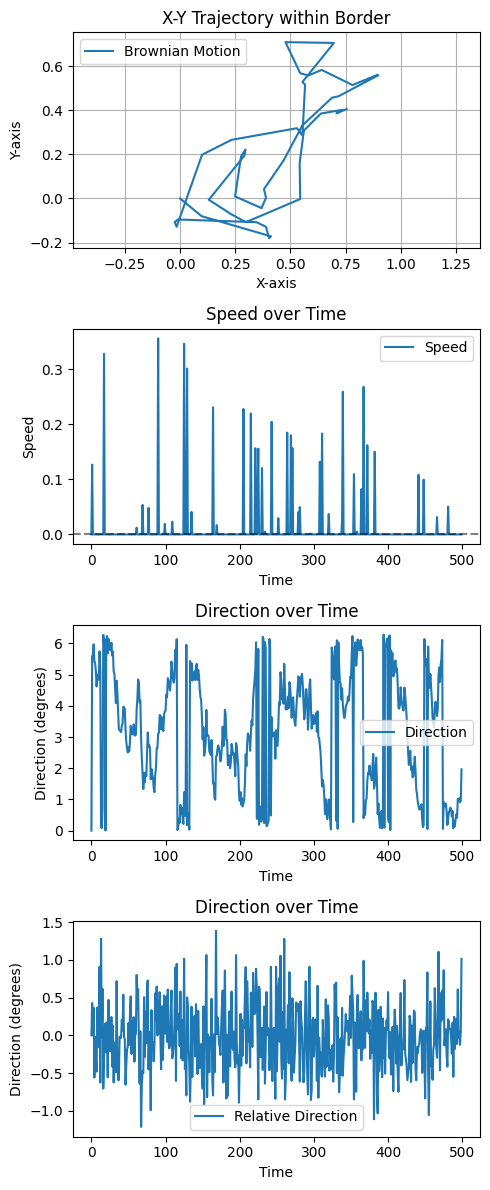

In [167]:
# Function to check if a point is inside the polygon
def is_inside_polygon(point, polygon):
  return polygon.contains(point)

# Function to resample direction based on Brownian motion
def resample_speed(current_speed,step_size):
  return abs(current_speed + np.random.normal(scale=np.sqrt(step_size/5)))

def brownian_walk_2d(num_steps, step_size, diffusion_coefficient, border_vertices, zero_prob = 0.9):
  border_polygon = Polygon(border_vertices)

  # Initialize arrays to store particle positions, speeds, and directions
  x = np.zeros(num_steps)
  y = np.zeros(num_steps)
  speeds = np.zeros(num_steps)
  directions = np.zeros(num_steps)
  delta_directions = np.zeros(num_steps)
  # Initial direction and position
  prev_direction = np.random.uniform(0, 2 * np.pi)
  speed = 0
  #x[0], y[0] = np.random.uniform(0, 5), np.random.uniform(0, 5)
  # Simulate Brownian motion
  for i in range(1, num_steps):
      # Resample direction based on Brownian motion
      theta = np.random.normal(scale=np.sqrt(2* step_size))
      direction = (prev_direction + theta) % (2*np.pi)
      speed = resample_speed(speed, step_size)
      # Calculate dx and dy components from the direction
      dx = speed * np.cos(direction)
      dy = speed * np.sin(direction)

      if np.random.rand() < zero_prob:  # 90% probability for speed to be 0
        dx, dy, speed = 0, 0, 0

      # Update particle position
      new_x = x[i - 1] + dx
      new_y = y[i - 1] + dy

      # Check if the new position is inside the border, adjust if necessary
      new_point = Point(new_x, new_y)

      count = 0
      while not is_inside_polygon(new_point, border_polygon):
          # If the new position is outside the border, resample the direction
          if count == 0:
            direction = -prev_direction
          elif count == 1:
            direction = prev_direction + np.pi
          elif count == 2:
            direction = prev_direction - np.pi
          else:
            direction = prev_direction + count * np.pi/10
            
          count += 1

          direction = direction % (2*np.pi)
          speed = resample_speed(speed, step_size)
          # Calculate dx and dy components from the direction
          dx = speed * np.cos(direction)
          dy = speed * np.sin(direction)
          # Update particle position
          new_x = x[i - 1] + dx
          new_y = y[i - 1] + dy

          # Check if the new position is inside the border, adjust if necessary
          new_point = Point(new_x, new_y)

      x[i] = x[i - 1] + dx
      y[i] = y[i - 1] + dy

      # Calculate speed and store direction
      speed = np.sqrt(dx**2 + dy**2)
      speeds[i] = speed
      directions[i] = direction
      delta_directions[i] = theta

      # Update previous direction
      prev_direction = direction

  return x,y,speeds,directions, delta_directions


# Parameters
num_steps = 500  # Number of steps
step_size = 0.1   # Step size
diffusion_coefficient = 0.1  # Diffusion coefficient

# Define the border polygon (you can change the vertices to define your border)
border_vertices = [(-1, -1), (1, -1), (1, 1), (-1, 1)]

x, y, speeds, directions, delta_directions = brownian_walk_2d(num_steps,step_size,diffusion_coefficient,border_vertices)

# Plot x-y trajectory, speed, and direction in separate plots
plt.figure(figsize=(5, 12))

# X-Y Trajectory
plt.subplot(4, 1, 1)
plt.plot(x, y, label='Brownian Motion')
plt.title('X-Y Trajectory within Border')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.axis('equal')
plt.legend()

# Speed
plt.subplot(4, 1, 2)
plt.plot(speeds, label='Speed')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Speed over Time')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()

# Direction
plt.subplot(4, 1, 3)
plt.plot(directions, label='Direction')
plt.title('Direction over Time')
plt.xlabel('Time')
plt.ylabel('Direction (degrees)')
plt.legend()

# Relative irection
plt.subplot(4, 1, 4)
plt.plot(delta_directions, label='Relative Direction')
plt.title('Direction over Time')
plt.xlabel('Time')
plt.ylabel('Direction (degrees)')
plt.legend()

plt.tight_layout()
plt.show()

In [266]:
def brownian_walk_2d(num_steps, step_size, diffusion_coefficient, border_vertices, zero_prob = 0.9):
  border_polygon = Polygon(border_vertices)

  # Initialize arrays to store particle positions, speeds, and directions
  x = np.zeros(num_steps)
  y = np.zeros(num_steps)
  speeds = np.zeros(num_steps)
  directions = np.zeros(num_steps)
  delta_directions = np.zeros(num_steps)
  # Initial direction and position
  prev_direction = np.random.uniform(0, 2 * np.pi)
  speed = 0
  #x[0], y[0] = np.random.uniform(0, 5), np.random.uniform(0, 5)
  # Simulate Brownian motion
  for i in range(1, num_steps):
      # Resample direction based on Brownian motion
      theta = np.random.normal(scale=np.sqrt(2* step_size))
      direction = (prev_direction + theta) % (2*np.pi)
      speed = resample_speed(speed, step_size)
      # Calculate dx and dy components from the direction
      dx = speed * np.cos(direction)
      dy = speed * np.sin(direction)

      if np.random.rand() < zero_prob:  # 90% probability for speed to be 0
        dx, dy, speed = 0, 0, 0

      # Update particle position
      new_x = x[i - 1] + dx
      new_y = y[i - 1] + dy

      # Check if the new position is inside the border, adjust if necessary
      new_point = Point(new_x, new_y)

      count = 0
      while not is_inside_polygon(new_point, border_polygon):
          # If the new position is outside the border, resample the direction

          theta = np.random.normal(scale=np.sqrt(2* step_size)) / 10 * count
          direction = prev_direction + theta
            
          count += 1

          direction = direction % (2*np.pi)
          speed = resample_speed(speed, step_size)
          # Calculate dx and dy components from the direction
          dx = speed * np.cos(direction)
          dy = speed * np.sin(direction)
          # Update particle position
          new_x = x[i - 1] + dx
          new_y = y[i - 1] + dy

          # Check if the new position is inside the border, adjust if necessary
          new_point = Point(new_x, new_y)

      x[i] = x[i - 1] + dx
      y[i] = y[i - 1] + dy

      # Calculate speed and store direction
      speed = np.sqrt(dx**2 + dy**2)
      speeds[i] = speed
      directions[i] = direction / (2*np.pi)
      delta_directions[i] = theta / (2*np.pi)
 
      # Update previous direction
      prev_direction = direction

  return x,y,speeds,directions, delta_directions

In [56]:
def rasterize_shape(vertices, granularity):
    # Find the bounding box of the shape
    x_coords, y_coords = zip(*vertices)
    min_x, min_y = min(x_coords), min(y_coords)
    max_x, max_y = max(x_coords), max(y_coords)

    # Create a grid within the bounding box with granularity 0.001
    x_range = np.arange(min_x, max_x, granularity)
    y_range = np.arange(min_y, max_y, granularity)

    # Create a mesh grid
    xx, yy = np.meshgrid(x_range, y_range)

    # Flatten the grid
    points = np.c_[xx.ravel(), yy.ravel()]

    # Check if each point is within the shape using the ray casting algorithm
    is_inside = np.array([is_point_inside_polygon(point, vertices) for point in points])

    # Reshape the inside points to match the grid shape
    is_inside = is_inside.reshape(xx.shape)

    return xx, yy, is_inside

def is_point_inside_polygon(point, vertices):
    x, y = point
    is_inside = False
    for i in range(len(vertices)):
        j = (i + 1) % len(vertices)
        if ((vertices[i][1] > y) != (vertices[j][1] > y)) and \
           (x < (vertices[j][0] - vertices[i][0]) * (y - vertices[i][1]) / (vertices[j][1] - vertices[i][1]) + vertices[i][0]):
            is_inside = not is_inside
    return is_inside
    #border_polygon = Polygon(vertices)
    #return border_polygon.contains(Point(x,y))

In [267]:
class PathDataset(torch.utils.data.Dataset):
    def __init__(self, velocity_sets, path_sets):
        self.velocity_sets = velocity_sets
        self.path_sets = path_sets

    def __len__(self):
        return len(self.velocity_sets)

    def __getitem__(self, idx):
      return {
          "inputs": torch.tensor(self.velocity_sets[idx]).float(),
          "labels": torch.tensor(self.path_sets[idx]).float()}

In [268]:
#Step 2: Format data into input, output labels for training and split into train/test set

def generate_dataset(num_steps, step_size, diffusion_coefficient, border_vertices, dataset_len):
  #initialize
  velocity_sets = np.zeros((dataset_len, num_steps, 2))
  path_sets = np.zeros((dataset_len, num_steps, 2))

  for i in tqdm(range(dataset_len)):
    x, y, speeds, directions, delta_directions = brownian_walk_2d(num_steps,step_size,diffusion_coefficient,border_vertices)

    path = np.stack([x, y], axis=1)
    velocities = np.stack([speeds, directions], axis=1)

    velocity_sets[i] = velocities
    path_sets[i] = path

  return velocity_sets, path_sets, dataset_len

Update rule ($h$ is hidden state with dimension $N$, $I$ is input with dimension $N_{in}$)
$$h_{i}(t+1) = h_i (t) + \frac{1}{\tau} \frac{\tau}{m_{\tau}} (-h_i (t) + \sum^N_{j=1} W_{ij}^{rec} tanh(h_i (t)) + \sum^{N_{in}}_{k=1} W_{ik}^{in} I_k(t) + b_i + noise_i(t))$$
Output:
$$y_j(t) = \sum_{i=1}^{N} W_{ij}^{out} tanh(h_i (t))$$

So in matrix form we have:

$$h(t+1) = h(t) + \frac{1}{\tau} \frac{\tau}{m_{\tau}} (-h(t) + W^{rec} tanh(h) + W^{in} I + b + noise(t))$$

And the firing rate of each neuron is:

$$tanh(h_i)$$

$dt = \tau / m_{\tau}$

In [265]:
class BioRNN(nn.Module):
  def __init__(self, config):
    super(BioRNN, self).__init__()
    self.input_dim = config["input_dim"]
    self.hidden_dim = config["hidden_dim"]
    self.output_dim = config["output_dim"]
    self.tau_multiplier = config["tau_multiplier"]

    self.W_in = nn.Linear(self.input_dim, self.hidden_dim, bias=False)
    self.W_rec = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
    self.W_out = nn.Linear(self.hidden_dim, self.output_dim, bias=False)
    self.b = nn.Parameter(torch.zeros((1, self.hidden_dim)))

  def __call__(self, input, noise):
    batch_size, time_steps, _ = input.shape
    x = torch.zeros((batch_size, self.hidden_dim)).to(input.device)
    outputs = torch.zeros((batch_size, time_steps, self.output_dim)).to(input.device)
    hidden_states = torch.zeros((batch_size, time_steps, self.hidden_dim)).to(input.device)

    for t in range(time_steps):
      inp = self.W_in(input[:,t,:])
      h = torch.tanh(x)
      rec = self.W_rec(h)
      x = x + self.tau_multiplier * (-x + inp + rec + self.b + noise[:,t,:])

      outputs[:,t,:] = self.W_out(x)
      hidden_states[:,t,:] = x
    
    l2_weights = [self.W_in.weight, self.W_out.weight]
    l2_weights = torch.cat([w.reshape(-1) for w in l2_weights])

    return outputs, hidden_states, l2_weights

  def initialize_weights(self):
    for name, param in self.named_parameters():
      if 'W_rec' in name:
        if 'weight' in name:
          nn.init.normal_(param, mean=config["rec_init"][0], std = config["rec_init"][1])
        if 'bias' in name:
          nn.init.zeros_(param)
      elif 'W_in' in name:
        if 'weight' in name:
          nn.init.normal_(param, mean=config["in_init"][0], std = config["in_init"][1])
        if 'bias' in name:
          nn.init.zeros_(param)
      elif 'W_out' in name:
        if 'weight' in name:
          nn.init.normal_(param, mean=config["out_init"][0], std = config["out_init"][1])
        if 'bias' in name:
          nn.init.zeros_(param)

In [ ]:
#Step 3: Intialize RNN with biological features
class RNN(nn.Module):
  def __init__(self, config):
    super(RNN, self).__init__()
    input_dim = config["input_dim"]
    hidden_dim = config["hidden_dim"]
    output_dim = config["output_dim"]
    self.tau_multiplier = config["tau_multiplier"]

    self.W_in = nn.Linear(input_dim, hidden_dim, bias=False)
    self.W_rec = nn.Linear(hidden_dim, hidden_dim, bias=False)
    self.W_out = nn.Linear(hidden_dim, output_dim, bias=False)
    self.b = nn.Parameter(torch.zeros((1, hidden_dim)))

  def __call__(self, input, h_prev, noise):
    inp = self.W_in(input)
    rec = self.W_rec(h_prev)
    h_current = h_prev + self.tau_multiplier * (-h_prev + inp + rec + self.b + noise)
    h_current = torch.tanh(h_current)
    y = self.W_out(h_current)
    return y, h_current, self.W_in.weight, self.W_out.weight

  def initialize_weights(self):
    for name, param in self.named_parameters():
      if 'W_rec' in name:
        if 'weight' in name:
          nn.init.normal_(param, mean=config["rec_init"][0], std = config["rec_init"][1])
        if 'bias' in name:
          nn.init.zeros_(param)
      elif 'W_in' in name:
        if 'weight' in name:
          nn.init.normal_(param, mean=config["in_init"][0], std = config["in_init"][1])
        if 'bias' in name:
          nn.init.zeros_(param)
      elif 'W_out' in name:
        if 'weight' in name:
          nn.init.normal_(param, mean=config["out_init"][0], std = config["out_init"][1])
        if 'bias' in name:
          nn.init.zeros_(param)

In [171]:
def scaled_frobenius_norm(matrix):
    squared_elements = matrix ** 2
    sum_of_squares = torch.sum(squared_elements)
    num_elements = matrix.numel()
    return sum_of_squares / num_elements

In [97]:
# Parameters
num_steps = data_config["time_steps"]  # Number of steps
step_size = data_config["step_size"]  # Step size
diffusion_coefficient = data_config["diffusion_coefficient"] # Diffusion coefficient
dataset_len = data_config["dataset_len"]
# Define the border polygon (you can change the vertices to define your border)
border_vertices = [(-1, -1), (1, -1), (1, 1), (-1, 1)]

velocity_sets, path_sets, dataset_len = generate_dataset(num_steps, step_size, diffusion_coefficient, border_vertices, dataset_len)
# dataset = PathDataset(velocity_sets, path_sets, noise_sets)
np.save(f"trainset_{dataset_len}_velocities_absolute", velocity_sets)
np.save(f"trainset_{dataset_len}_paths_absolute", path_sets)

100%|██████████| 100000/100000 [27:21<00:00, 60.91it/s]


In [98]:
# Parameters
num_steps = data_config["time_steps"]  # Number of steps
step_size = data_config["step_size"]  # Step size
diffusion_coefficient = data_config["diffusion_coefficient"] # Diffusion coefficient
dataset_len = data_config["validset_len"]
border_vertices = data_config["vertices"]

velocity_sets, path_sets, dataset_len = generate_dataset(num_steps, step_size, diffusion_coefficient, border_vertices, dataset_len)
# dataset = PathDataset(velocity_sets, path_sets, noise_sets)
np.save(f"validset_{dataset_len}_velocities_absolute", velocity_sets)
np.save(f"validset_{dataset_len}_paths_absolute", path_sets)

 17%|█▋        | 3440/20000 [00:53<04:26, 62.05it/s]

100%|██████████| 20000/20000 [05:21<00:00, 62.15it/s]


In [163]:
#add to sets
num_steps = data_config["time_steps"]  # Number of steps
step_size = data_config["step_size"]  # Step size
diffusion_coefficient = data_config["diffusion_coefficient"] # Diffusion coefficient
border_vertices = data_config["vertices"]

velocity_sets, path_sets, dataset_len = generate_dataset(num_steps, step_size, diffusion_coefficient, border_vertices, data_config["dataset_len"])
valid_velocity_sets, valid_path_sets, validset_len = generate_dataset(num_steps, step_size, diffusion_coefficient, border_vertices, data_config["validset_len"])

old_train_velocity_sets = np.load(f"trainset_{dataset_len}_velocities_absolute.npy")
old_train_path_sets = np.load(f"trainset_{dataset_len}_paths_absolute.npy")
old_valid_velocity_sets = np.load(f"validset_{validset_len}_velocities_absolute.npy")
old_valid_path_sets = np.load(f"validset_{validset_len}_paths_absolute.npy")

new_train_velocity_sets = np.concatenate((old_train_velocity_sets, velocity_sets), axis=0)
new_train_path_sets = np.concatenate((old_train_path_sets, path_sets), axis=0)
new_valid_velocity_sets = np.concatenate((old_valid_velocity_sets, valid_velocity_sets), axis=0)
new_valid_path_sets = np.concatenate((old_valid_path_sets, valid_path_sets), axis=0)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [04:09<00:00, 80.15it/s]


In [160]:
a = "trainset_30000_velocities_absolute_partial1.npy"
x = "trainset_30000_paths_absolute_partial1.npy"


b = "trainset_30000_velocities_absolute_partial2.npy"
c = "trainset_30000_velocities_absolute_partial3.npy"
d = "trainset_30000_velocities_absolute_partial5.npy"

y = "trainset_30000_paths_absolute_partial2.npy"
w = "trainset_30000_paths_absolute_partial3.npy"
z = "trainset_30000_paths_absolute_partial5.npy"


l = "validset_100000_velocities_absolute.npy"
m = "validset_100000_paths_absolute.npy"

a1 = "validset_10000_velocities_absolute_partial1.npy"
b1 = "validset_10000_velocities_absolute_partial2.npy"
c1 = "validset_10000_velocities_absolute_partial3.npy"
d1 = "validset_10000_velocities_absolute_partial5.npy"

x1 = "validset_10000_paths_absolute_partial1.npy"
y1 = "validset_10000_paths_absolute_partial2.npy"
w1 = "validset_10000_paths_absolute_partial5.npy"
z1 = "validset_10000_paths_absolute_partial3.npy"

train_velocity = [c, d, l, a1, b1, c1, d1]
train_path = [w, z, m, x1, y1, w1, z1]

final_train_velocity = np.load(b)
final_train_path = np.load(y)
for name in train_velocity:
  final_train_velocity = np.concatenate((final_train_velocity, np.load(name)), axis=0)
for name in train_path:
    final_train_path = np.concatenate((final_train_path, np.load(name)), axis=0)
final_valid_velocity = np.load(a)
final_valid_path = np.load(x)

np.save(f"trainset_230000_velocities_absolute_final", final_train_velocity)
np.save(f"trainset_230000_paths_absolute_final", final_train_path)
np.save(f"validset_30000_velocities_absolute_final", final_valid_velocity)
np.save(f"validset_30000_paths_absolute_final", final_valid_path)

In [165]:
np.save(f"trainset_{200000}_velocities_absolute", new_train_velocity_sets)
np.save(f"trainset_{200000}_paths_absolute", new_train_path_sets)
np.save(f"validset_{40000}_velocities_absolute", new_valid_velocity_sets)
np.save(f"validset_{40000}_paths_absolute", new_valid_path_sets)

In [6]:
dataset_len = data_config["dataset_len"]
velocity_sets = np.load(f"trainset_{dataset_len}_velocities.npy")
path_sets = np.load(f"trainset_{dataset_len}_paths.npy")
dataset = PathDataset(velocity_sets, path_sets)
trainloader = DataLoader(dataset, batch_size=data_config["batch_size"], shuffle=True)

In [7]:
dataset_len = 20000
velocity_sets = np.load(f"validset_{dataset_len}_velocities.npy")
path_sets = np.load(f"validset_{dataset_len}_paths.npy")
dataset = PathDataset(velocity_sets, path_sets)
validloader = DataLoader(dataset, batch_size=data_config["batch_size"], shuffle=False)

In [264]:
class BioLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BioLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Input gate layers
        self.Wii = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size)
        self.bi = nn.Parameter(torch.zeros(hidden_size))

        # Forget gate layers
        self.Wif = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size)
        self.bf = nn.Parameter(torch.zeros(hidden_size))

        # Cell gate layers
        self.Wig = nn.Linear(input_size, hidden_size)
        self.Whg = nn.Linear(hidden_size, hidden_size)
        self.bg = nn.Parameter(torch.zeros(hidden_size))

        # Output gate layers
        self.Wio = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size)
        self.bo = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, init_states):
        """
        forward method for the LSTM cell.
        """
        h_t, c_t = init_states

        i_t = torch.sigmoid(self.Wii(x) + self.Whi(h_t) + self.bi)
        f_t = torch.sigmoid(self.Wif(x) + self.Whf(h_t) + self.bf)
        g_t = torch.tanh(self.Wig(x) + self.Whg(h_t) + self.bg)
        o_t = torch.sigmoid(self.Wio(x) + self.Who(h_t) + self.bo)

        c_t = f_t * c_t + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t
    
    def initialize_weights(self):
      for name, param in self.named_parameters():
        if 'W' in name:
          if 'h' in name:
            nn.init.normal_(param, mean=config["rec_init"][0], std = config["rec_init"][1])
          elif 'i' in name:
            nn.init.normal_(param, mean=config["in_init"][0], std = config["in_init"][1])
          if 'bias' in name:
            nn.init.zeros_(param)

In [263]:
class BioLSTM(nn.Module):
    def __init__(self, config):
        super(BioLSTM, self).__init__()
        self.cell = BioLSTMCell(config["input_dim"], config["hidden_dim"])
        self.hidden_size = config["hidden_dim"]
        self.output_size = config["output_dim"]

        self.W_out = nn.Linear(self.hidden_size, config["output_dim"])
        self.b_c = nn.Parameter(torch.zeros((1, self.hidden_size)))
        self.b_h = nn.Parameter(torch.zeros((1, self.hidden_size)))
        self.tau_multiplier = config["tau_multiplier"]

    def forward(self, x, noises):
        """
        forward method for the LSTM.
        """
        bs, seq_sz, _ = x.size()

        h_t = torch.zeros(bs, self.hidden_size).to(x.device)
        c_t = torch.zeros(bs, self.hidden_size).to(x.device)

        hidden_states = torch.zeros(bs, seq_sz, self.hidden_size).to(x.device)
        outputs = torch.zeros(bs, seq_sz, self.output_size).to(x.device)

        for t in range(seq_sz):
            x_t = x[:, t, :]
            new_h_t, c_t = self.cell(x_t, (h_t, c_t))
            h_t = h_t + self.tau_multiplier * (-h_t + new_h_t + noises[:,t,:] + self.b_h)
            hidden_states[:,t,:] = h_t
            outputs[:,t,:] = self.W_out(h_t)
        
        l2_weights = [self.cell.Wii.weight, self.cell.Wif.weight, self.cell.Wig.weight, self.cell.Wio.weight]
        l2_weights = torch.cat([w.reshape(-1) for w in l2_weights])

        return outputs, hidden_states, l2_weights

    def initialize_weights(self):
      for name, param in self.named_parameters():
        if 'W' in name:
          if 'h' in name:
            nn.init.normal_(param, mean=config["rec_init"][0], std = config["rec_init"][1])
          elif 'i' in name:
            nn.init.normal_(param, mean=config["in_init"][0], std = config["in_init"][1])
          elif 'out' in name:
            nn.init.normal_(param, mean=config["out_init"][0], std = config["out_init"][1])
          if 'bias' in name:
            nn.init.zeros_(param)
      self.cell.initialize_weights()

In [262]:
model = BioLSTM(config)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.initialize_weights()

In [47]:
def evaluate(model, loss_fn, dataloader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader)):
      inputs = batch["inputs"].to(device)
      labels = batch["labels"].to(device)
      bs, ts, _ = inputs.shape
      noises = torch.zeros(bs, ts, 1).to(device)
      outputs, hidden_state, l2_weights = model(inputs, noises)

      loss = loss_fn(outputs, labels)
      total_loss += loss.item()
  
  #return average loss per sample
  return total_loss / len(dataloader)
  

In [ ]:
from __future__ import generator_stop
#Step 4: Train RNN
optimizer = Adam(model.parameters(), lr=0.0005)
loss_fn = MSELoss()

train_losses = []
valid_losses = []

model.train()

for epoch in range(config["epochs"]):
  epoch_loss = 0
  for i, batch in enumerate(tqdm(trainloader)):
    optimizer.zero_grad()

    num_steps = batch["inputs"].shape[1]
    batch_size = batch["inputs"].shape[0]

    inputs = batch["inputs"].reshape(num_steps, batch_size, -1).to(device)
    labels = batch["labels"].reshape(num_steps, batch_size, -1).to(device)
    noises = torch.normal(0.0, config["noise_variance"], size=(num_steps, batch_size, config["hidden_dim"])).to(device)

    hidden_state = torch.zeros((batch_size, config["hidden_dim"])).to(device)

    batch_loss = 0
    outputs = torch.zeros((num_steps, batch_size, config["output_dim"])).to(device)
    for input, label, noise in zip(inputs, labels, noises):
        output, hidden_state, W_in, W_out = model(input, hidden_state, noise)
        outputs[i] = output
        loss = loss_fn(output, label)
        batch_loss += loss

    epoch_loss += batch_loss
    train_loss = batch_loss / num_steps
    train_losses.append(train_loss)

    l2_reg = scaled_frobenius_norm(W_in) + scaled_frobenius_norm(W_out)
    metabolic_reg = scaled_frobenius_norm(hidden_state)
    batch_loss += l2_reg + metabolic_reg
    batch_loss.backward()
    optimizer.step()

    if i % 50 == 0:
      eval_loss = evaluate(model, loss_fn, validloader)
      valid_losses.append(eval_loss)
      print("Epoch: {} Batch: {} Train Loss: {} Eval Loss: {}".format(epoch+1, i, train_loss, eval_loss))
      model.train()

  print("Epoch: {} Train Loss: {}".format(epoch+1, epoch_loss / (num_steps * len(trainloader))))

  if epoch % 2 == 0:
    plt.figure(figsize=(4, 2))
    plt.plot(train_losses)
    plt.title("Train loss over time")
    plt.xlabel("Steps")
    plt.ylabel("Loss")

    plt.figure(figsize=(4, 2))
    plt.plot(valid_losses)
    plt.title("Valid loss over time")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.show()

In [ ]:
#Step 4: Train RNN
optimizer = Adam(model.parameters(), lr=config["lr"])
loss_fn = MSELoss()

train_losses = []
valid_losses = []

model.train()

l_2_multiplier = 1
metabolic_reg_multiplier = 1

for epoch in range(config["epochs"]):
  epoch_loss = 0
  for i, batch in enumerate(tqdm(trainloader)):
    optimizer.zero_grad()

    labels = batch["labels"].to(device)
    inputs = batch["inputs"].to(device)
    
    noises = torch.normal(0.0, data_config["noise_variance"], size=(data_config["batch_size"], data_config["time_steps"], config["hidden_dim"])).to(device)
    outputs, hidden_state, l2_weights = model(inputs, noises)

    loss = loss_fn(outputs, labels)
    epoch_loss += loss.item()
    train_losses.append(loss.item())
                
    l2_reg = scaled_frobenius_norm(l2_weights)
    l2_multiplier = loss.item() / l2_reg * ((len(trainloader) - i) / len(trainloader))
    metabolic_reg = scaled_frobenius_norm(hidden_state)
    metabolic_reg_multiplier = (loss.item() / metabolic_reg) * (i / len(trainloader))
    if metabolic_reg_multiplier > loss / 3: 
      metabolic_reg_multiplier = loss / 3
    loss += l2_reg * l_2_multiplier + metabolic_reg * metabolic_reg_multiplier
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
      eval_loss = evaluate(model, loss_fn, validloader)
      print("Epoch: {} Step: {} Train Loss: {} Valid Loss: {}".format(epoch+1, i, epoch_loss / (i+1), eval_loss))
      valid_losses.append(eval_loss)
      model.train()
    
  print("Epoch: {} Train Loss: {}".format(epoch+1, epoch_loss / (num_steps * len(trainloader))))

  if epoch % 2 == 0:
    plt.figure(figsize=(4, 2))
    plt.plot(train_losses)
    plt.title("Train loss over time")
    plt.xlabel("Steps")
    plt.ylabel("Loss")

    plt.figure(figsize=(4, 2))
    plt.plot(valid_losses)
    plt.title("Valid loss over time")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.show()
  



### Step 5: RNN Analysis

In [173]:
class RNNWithLinearPerTimestep(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNWithLinearPerTimestep, self).__init__()
        # RNN Layer
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Linear output layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        # Pass the input through the RNN layer
        # out shape: [batch_size, seq_length, hidden_size]
        hidden_states, _ = self.rnn(input)

        # Reshape output for linear layer
        # New shape: [batch_size * seq_length, hidden_size]
        batch_size, seq_length, hidden_size = hidden_states.shape
        out = hidden_states.reshape(batch_size * seq_length, hidden_size)

        # Pass each time step through the linear layer
        # out shape: [batch_size * seq_length, output_size]
        out = self.linear(out)

        # Reshape back to out: [batch_size, seq_length, output_size]
        out = out.reshape(batch_size, seq_length, -1)
        # hidden_states: [batch_size, seq_length, hidden_size]
        return out, hidden_states

In [174]:
#load model with state dict
model = RNNWithLinearPerTimestep(2, 100, 2, 1)
model.load_state_dict(torch.load("reg_lstm_200k.pt"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

RNNWithLinearPerTimestep(
  (rnn): LSTM(2, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
num_steps = data_config["time_steps"]  # Number of steps
step_size = data_config["step_size"]  # Step size
diffusion_coefficient = data_config["diffusion_coefficient"] # Diffusion coefficient
dataset_len = 1
# Define the border polygon (you can change the vertices to define your border)
border_vertices = [(-1, -1), (1, -1), (1, 1), (-1, 1)]

velocity_sets, path_sets, dataset_len = generate_dataset(num_steps, step_size, diffusion_coefficient, border_vertices, dataset_len)
dataset = PathDataset(velocity_sets, path_sets)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
sample = next(iter(dataloader))
num_steps = sample["inputs"].shape[1]
batch_size = sample["inputs"].shape[0]
print(sample["inputs"].shape)
print(sample["inputs"][:, 20, :])
reshaped = sample["inputs"].reshape(num_steps, batch_size, -1)
print(reshaped.shape)
print(reshaped[20, :, :])
v = velocity_sets[0]
p = path_sets[0]

for i in range(100):
    print(v[i])
    print(sample["inputs"][:, i, :])
    print(reshaped[i, :, :])
    print(sample["labels"][:, i, :])
    print(p[i])
    print("")

In [ ]:
dataset_len = data_config["validset_len"]
velocity_sets = np.load(f"validset_{dataset_len}_velocities.npy")
path_sets = np.load(f"validset_{dataset_len}_paths.npy")
dataset = PathDataset(velocity_sets, path_sets)
sample = dataset.__getitem__(np.random.randint(0, len(dataset)))
real_labels = sample["labels"]

xs = []
ys = []

model.eval()
with torch.no_grad():
    num_steps = len(real_labels)
    batch_size = 1

    inputs = sample["inputs"].reshape(num_steps, batch_size, -1).to(device)
    labels = sample["labels"].reshape(num_steps, batch_size, -1).to(device)
    # noises = torch.normal(0.0, data_config["noise_variance"], size=(num_steps, batch_size, config["hidden_dim"])).to(device)
    noises = torch.zeros((num_steps, batch_size, config["hidden_dim"])).to(device)

    hidden_state = torch.zeros((1, config["hidden_dim"])).to(device)

    print(inputs.shape)
    print(labels.shape)
    print(noises.shape)
    print(hidden_state.shape)

    for input, label, noise in zip(inputs, labels, noises):
        output, hidden_state, W_in, W_out = model(input, hidden_state, noise)
        xs.append(output[0][0].item())
        ys.append(output[0][1].item())

plt.figure(figsize=(8, 6))
plt.plot(xs, ys, marker='o', linestyle='-', color='b', label="Predicted")
plt.plot(real_labels[:, 0], real_labels[:, 1], marker='o', linestyle='-', color='r', label="Actual")
plt.title('Position Over Time')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True)
plt.tight_layout()
plt.legend()

In [257]:
class SemiBioLSTM(nn.Module):
    def __init__(self, config):
        super(SemiBioLSTM, self).__init__()
        self.cell = BioLSTMCell(config["input_dim"], config["hidden_dim"])
        self.hidden_size = config["hidden_dim"]
        self.output_size = config["output_dim"]

        self.W_out = nn.Linear(self.hidden_size, config["output_dim"])
        self.b_c = nn.Parameter(torch.zeros((1, self.hidden_size)))
        self.b_h = nn.Parameter(torch.zeros((1, self.hidden_size)))
        self.tau_multiplier = config["tau_multiplier"]

    def forward(self, x, noises):
        """
        forward method for the LSTM.
        """
        bs, seq_sz, _ = x.size()

        h_t = torch.zeros(bs, self.hidden_size).to(x.device)
        c_t = torch.zeros(bs, self.hidden_size).to(x.device)

        hidden_states = torch.zeros(bs, seq_sz, self.hidden_size).to(x.device)
        outputs = torch.zeros(bs, seq_sz, self.output_size).to(x.device)

        for t in range(seq_sz):
            x_t = x[:, t, :]
            h_t, c_t = self.cell(x_t, (h_t, c_t))
            hidden_states[:,t,:] = h_t
            outputs[:,t,:] = self.W_out(h_t)
        
        l2_weights = [self.cell.Wii.weight, self.cell.Wif.weight, self.cell.Wig.weight, self.cell.Wio.weight]
        l2_weights = torch.cat([w.reshape(-1) for w in l2_weights])

        return outputs, hidden_states, l2_weights
    
    def initialize_weights(self):
      for name, param in self.named_parameters():
        if 'W' in name:
          if 'h' in name:
            nn.init.normal_(param, mean=config["rec_init"][0], std = config["rec_init"][1])
          elif 'i' in name:
            nn.init.normal_(param, mean=config["in_init"][0], std = config["in_init"][1])
          elif 'out' in name:
            nn.init.normal_(param, mean=config["out_init"][0], std = config["out_init"][1])
          if 'bias' in name:
            nn.init.zeros_(param)
      self.cell.initialize_weights()

In [285]:
# model = RNNWithLinearPerTimestep(hidden_size=100, input_size=2, output_size=2, num_layers=1)
model = BioLSTM(config)
model.load_state_dict(torch.load("bio_lstm_2kbatch_230kdata_0.01noise.pt"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

BioLSTM(
  (cell): BioLSTMCell(
    (Wii): Linear(in_features=2, out_features=100, bias=True)
    (Whi): Linear(in_features=100, out_features=100, bias=True)
    (Wif): Linear(in_features=2, out_features=100, bias=True)
    (Whf): Linear(in_features=100, out_features=100, bias=True)
    (Wig): Linear(in_features=2, out_features=100, bias=True)
    (Whg): Linear(in_features=100, out_features=100, bias=True)
    (Wio): Linear(in_features=2, out_features=100, bias=True)
    (Who): Linear(in_features=100, out_features=100, bias=True)
  )
  (W_out): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()

# dataset_len = data_config["validset_len"]
# velocity_sets = np.load(f"validset_{dataset_len}_velocities_absolute.npy")
# path_sets = np.load(f"validset_{dataset_len}_paths_absolute.npy")
# dataset = PathDataset(velocity_sets, path_sets)
# sample = dataset.__getitem__(np.random.randint(0, len(dataset)))
# real_labels = sample["labels"]

dataset_len = 30000
velocity_sets = np.load(f"validset_{dataset_len}_velocities_absolute_final.npy")
path_sets = np.load(f"validset_{dataset_len}_paths_absolute_final.npy")
dataset = PathDataset(velocity_sets, path_sets)
sample = dataset.__getitem__(np.random.randint(0, len(dataset)))
real_labels = sample["labels"]

xs = []
ys = []

model.eval()
total_loss = 0
with torch.no_grad():
    num_steps = len(real_labels)

    inputs = sample["inputs"].reshape(1, num_steps, -1).to(device)
    labels = sample["labels"].reshape(1, num_steps, -1).to(device)
    #[batch_size, seq_length, output_size/hidden_size]
    outputs, hidden_states = model(inputs)
    xs = outputs[0, :, 0].detach().cpu().numpy()
    ys = outputs[0, :, 1].detach().cpu().numpy()

    loss = loss_fn(outputs, labels)
    total_loss += loss.item()

print(total_loss)

plt.figure(figsize=(8, 6))
plt.plot(xs, ys, linestyle='-', color='b', label="Predicted")
plt.plot(real_labels[:, 0], real_labels[:, 1], linestyle='-', color='r', label="Actual")
plt.title('Position Over Time')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True)
plt.tight_layout()
plt.legend()

0.09414825588464737


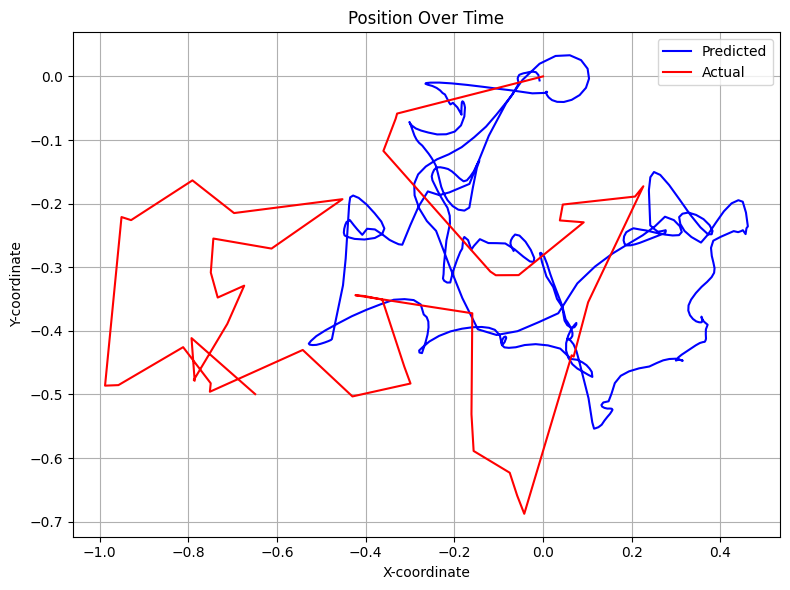

In [292]:
loss_fn = nn.MSELoss()

# dataset_len = data_config["validset_len"]
# velocity_sets = np.load(f"validset_{dataset_len}_velocities_absolute.npy")
# path_sets = np.load(f"validset_{dataset_len}_paths_absolute.npy")
# dataset = PathDataset(velocity_sets, path_sets)
# sample = dataset.__getitem__(np.random.randint(0, len(dataset)))
# real_labels = sample["labels"]

dataset_len = 30000
velocity_sets = np.load(f"validset_{dataset_len}_velocities_absolute_final.npy")
path_sets = np.load(f"validset_{dataset_len}_paths_absolute_final.npy")
dataset = PathDataset(velocity_sets, path_sets)
sample = dataset.__getitem__(np.random.randint(0, len(dataset)))
real_labels = sample["labels"]

xs = []
ys = []

model.eval()
total_loss = 0
with torch.no_grad():
    num_steps = len(real_labels)

    inputs = sample["inputs"].reshape(1, num_steps, -1).to(device)
    labels = sample["labels"].reshape(1, num_steps, -1).to(device)
    noises = torch.zeros((1, num_steps, config["hidden_dim"])).to(device)
    #[batch_size, seq_length, output_size/hidden_size]
    outputs, hidden_states, _ = model(inputs, noises)
    xs = outputs[0, :, 0].detach().cpu().numpy()
    ys = outputs[0, :, 1].detach().cpu().numpy()

    loss = loss_fn(outputs, labels)
    total_loss += loss.item()

print(total_loss)

plt.figure(figsize=(8, 6))
plt.plot(xs, ys, linestyle='-', color='b', label="Predicted")
plt.plot(real_labels[:, 0], real_labels[:, 1], linestyle='-', color='r', label="Actual")
plt.title('Position Over Time')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True)
plt.tight_layout()
plt.legend()

In [100]:
model.eval()
total_loss = 0
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader)):
        inputs = batch["inputs"].to(device)
        labels = batch["labels"].to(device)

        outputs, _ = model(inputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

#return average loss per sample
print(total_loss / len(dataloader))

100%|██████████| 20000/20000 [00:30<00:00, 661.02it/s]

0.0014561188271611173


In [271]:
num_steps = 1000000
step_size = data_config["step_size"]  # Step size
diffusion_coefficient = data_config["diffusion_coefficient"] # Diffusion coefficient
dataset_len = 1
border_vertices = data_config["vertices"]

velocity_sets, path_sets, dataset_len = generate_dataset(num_steps, step_size, diffusion_coefficient, border_vertices, dataset_len)
velocities = velocity_sets[0]
paths = path_sets[0]

100%|██████████| 1/1 [00:26<00:00, 26.67s/it]


In [178]:
with torch.no_grad():
    inputs = torch.tensor(velocities).reshape(1, num_steps, -1).float().to(device)
    labels = torch.tensor(paths).reshape(1, num_steps, -1).float().to(device)
    #[batch_size, seq_length, output_size/hidden_size]
    outputs, hidden_states = model(inputs)
    # xs = outputs[0, :, 0].detach().cpu().numpy()
    # ys = outputs[0, :, 1].detach().cpu().numpy()
    xs = labels[0, :, 0].detach().cpu().numpy()
    ys = labels[0, :, 1].detach().cpu().numpy()
    print(hidden_states.shape)
    hidden_states = hidden_states[0, :, :].detach().cpu().numpy()
    

torch.Size([1, 1000000, 100])


In [272]:
with torch.no_grad():
    inputs = torch.tensor(velocities).reshape(1, num_steps, -1).float().to(device)
    labels = torch.tensor(paths).reshape(1, num_steps, -1).float().to(device)
    noises = torch.zeros((1, num_steps, config["hidden_dim"])).to(device)
    print(inputs.shape)
    #[batch_size, seq_length, output_size/hidden_size]
    outputs, hidden_states, _ = model(inputs, noises)
    # xs = outputs[0, :, 0].detach().cpu().numpy()
    # ys = outputs[0, :, 1].detach().cpu().numpy()
    xs = labels[0, :, 0].detach().cpu().numpy()
    ys = labels[0, :, 1].detach().cpu().numpy()
    print(hidden_states.shape)
    hidden_states = hidden_states[0, :, :].detach().cpu().numpy()

torch.Size([1, 1000000, 2])


torch.Size([1, 1000000, 100])


0


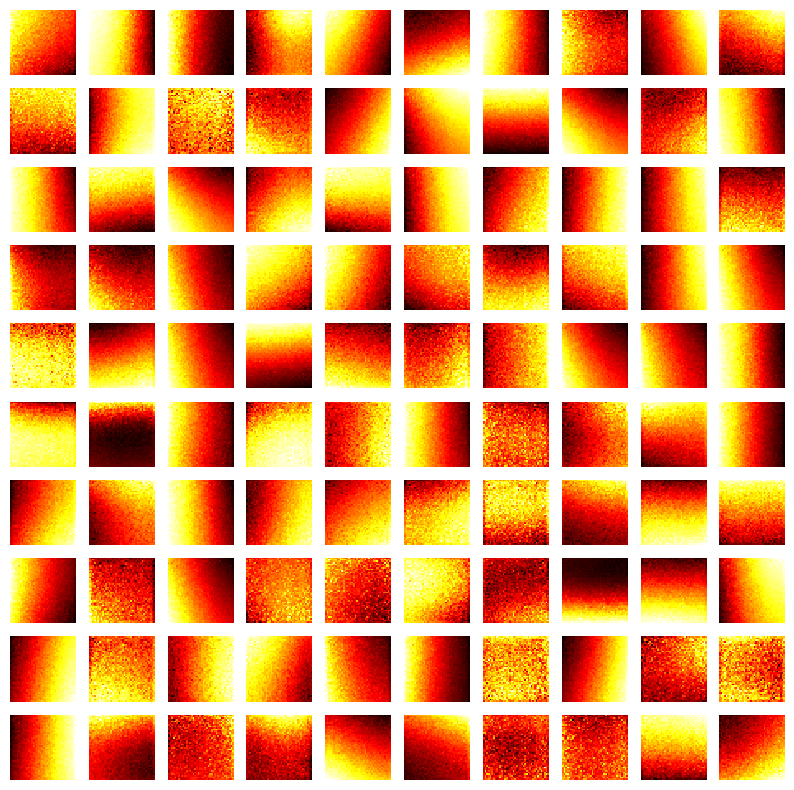

In [275]:
# Rasterize the shape
vertices = data_config["vertices"]
granularity = 0.05

x_coords, y_coords = zip(*vertices)
min_x, min_y = min(x_coords), min(y_coords)
max_x, max_y = max(x_coords), max(y_coords)
activation_matrix = np.zeros((int((max_x - min_x) / granularity), 
                              int((max_y - min_y) / granularity), 
                              config["hidden_dim"]))
count_matrix = np.zeros((int((max_x - min_x) / granularity),
                          int((max_y - min_y) / granularity)))

model.eval()
count = 0

for timestep in range(num_steps):
    x_value = xs[timestep]
    y_value = ys[timestep]

    if x_value < min_x or x_value > max_x or y_value < min_y or y_value > max_y:
        count += 1
        continue

    x_index = int((x_value - min_x) / granularity)
    y_index = int((y_value - min_y) / granularity)
    hidden_state = hidden_states[timestep]

    activation_matrix[x_index, y_index] += hidden_state
    count_matrix[x_index, y_index] += 1
      
print(count)

# Normalize the activation matrix
for i in range(activation_matrix.shape[0]):
    for j in range(activation_matrix.shape[1]):
        if count_matrix[i, j] != 0:
            activation_matrix[i, j] /= count_matrix[i, j]

# Plot the activation matrix for each hidden unit
plt.figure(figsize=(10, 10))
for i in range(config["hidden_dim"]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(activation_matrix[:, :, i], cmap='hot', interpolation='nearest')
    plt.axis('off')


In [135]:
# Rasterize the shape
vertices = data_config["vertices"]
granularity = 0.01

# xx, yy, is_inside = rasterize_shape(vertices, granularity)
# max_x, min_x, max_y, min_y = max(xx[0]), min(xx[0]), max(yy[:, 0]), min(yy[:, 0])
# activation_matrix = np.zeros((len(xx), len(yy), config["hidden_dim"]))

x_coords, y_coords = zip(*vertices)
min_x, min_y = min(x_coords), min(y_coords)
max_x, max_y = max(x_coords), max(y_coords)
activation_matrix = np.zeros((int((max_x - min_x) / granularity), 
                              int((max_y - min_y) / granularity), 
                              config["hidden_dim"]))
count_matrix = np.zeros((int((max_x - min_x) / granularity),
                          int((max_y - min_y) / granularity)))

repetitions = 1

model.eval()

with torch.no_grad():
  for epoch in range(repetitions):
    epoch_loss = 0
    for i, batch in enumerate(tqdm(validloader)):

      num_steps = batch["inputs"].shape[1]
      batch_size = batch["inputs"].shape[0]

      inputs = batch["inputs"].reshape(batch_size, num_steps, -1).to(device)
      labels = batch["labels"].reshape(batch_size, num_steps, -1).to(device)

      #[batch_size, seq_length, output_size/hidden_size]
      outputs, hidden_states = model(inputs)
      outputs = outputs.detach().cpu().numpy()
      hidden_states = hidden_states.detach().cpu().numpy()

      # Flatten the indices and hidden states
      flat_x_indices = x_indices.flatten()
      flat_y_indices = y_indices.flatten()
      flat_hidden_states = hidden_states.reshape(-1, hidden_states.shape[-1])

      # Update activation_matrix and count_matrix using vectorized operations
      np.add.at(activation_matrix, (flat_x_indices, flat_y_indices), flat_hidden_states)
      np.add.at(count_matrix, (flat_x_indices, flat_y_indices), 1)

      
      
activation_matrix = activation_matrix / config["epochs"]
count_matrix = count_matrix / config["epochs"]


  0%|          | 0/20000 [00:00<?, ?it/s]


IndexError: index 1005 is out of bounds for axis 0 with size 200

In [45]:
dataset_len = 100000
velocity_sets = np.load(f"trainset_{dataset_len}_velocities.npy")
path_sets = np.load(f"trainset_{dataset_len}_paths.npy")
dataset = PathDataset(velocity_sets, path_sets)
validloader = DataLoader(dataset, batch_size=1)

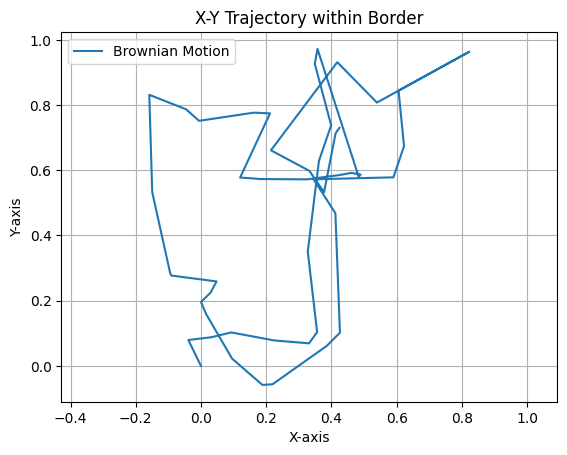

In [47]:
one_run = dataset[20]
labels = one_run["labels"].reshape(-1, 2)
plt.plot(labels[:, 0].cpu().numpy(), labels[:, 1].cpu().numpy(), label='Brownian Motion')
plt.title('X-Y Trajectory within Border')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.axis('equal')
plt.legend()

In [ ]:
# Rasterize the shape
vertices = data_config["vertices"]
granularity = data_config["granularity"]

# xx, yy, is_inside = rasterize_shape(vertices, granularity)
# max_x, min_x, max_y, min_y = max(xx[0]), min(xx[0]), max(yy[:, 0]), min(yy[:, 0])
# activation_matrix = np.zeros((len(xx), len(yy), config["hidden_dim"]))

x_coords, y_coords = zip(*vertices)
min_x, min_y = min(x_coords), min(y_coords)
max_x, max_y = max(x_coords), max(y_coords)
activation_matrix = np.zeros((int((max_x - min_x) / granularity), 
                              int((max_y - min_y) / granularity), 
                              config["hidden_dim"]))
count_matrix = np.zeros((int((max_x - min_x) / granularity),
                          int((max_y - min_y) / granularity)))

repetitions = 1

model.eval()

with torch.no_grad():
  for epoch in range(repetitions):
    epoch_loss = 0
    for i, batch in enumerate(tqdm(validloader)):

      num_steps = batch["inputs"].shape[1]
      batch_size = batch["inputs"].shape[0]

      inputs = batch["inputs"].reshape(num_steps, batch_size, -1).to(device)
      labels = batch["labels"].reshape(num_steps, batch_size, -1).to(device)
      noises = torch.normal(0.0, data_config["noise_variance"], size=(num_steps, batch_size, config["hidden_dim"])).to(device)

      hidden_state = torch.zeros((1, config["hidden_dim"])).to(device)

      for input, label, noise in zip(inputs, labels, noises):
        output, hidden_state, W_in, W_out = model(input, hidden_state, noise)
        hidden_state = hidden_state.detach()

        output = output.detach().cpu().numpy()
        label = label.detach().cpu().numpy()
        x_values = label[:, 0]
        y_values = label[:, 1]
        x_indices = ((x_values - min_x) / granularity).astype(int)
        y_indices = ((y_values - min_y) / granularity).astype(int)

        for j in range(batch_size):
          activation_matrix[x_indices[j], y_indices[j]] += hidden_state[j].cpu().numpy()
          count_matrix[x_indices[j], y_indices[j]] += 1


activation_matrix = activation_matrix / config["epochs"]
count_matrix = count_matrix / config["epochs"]


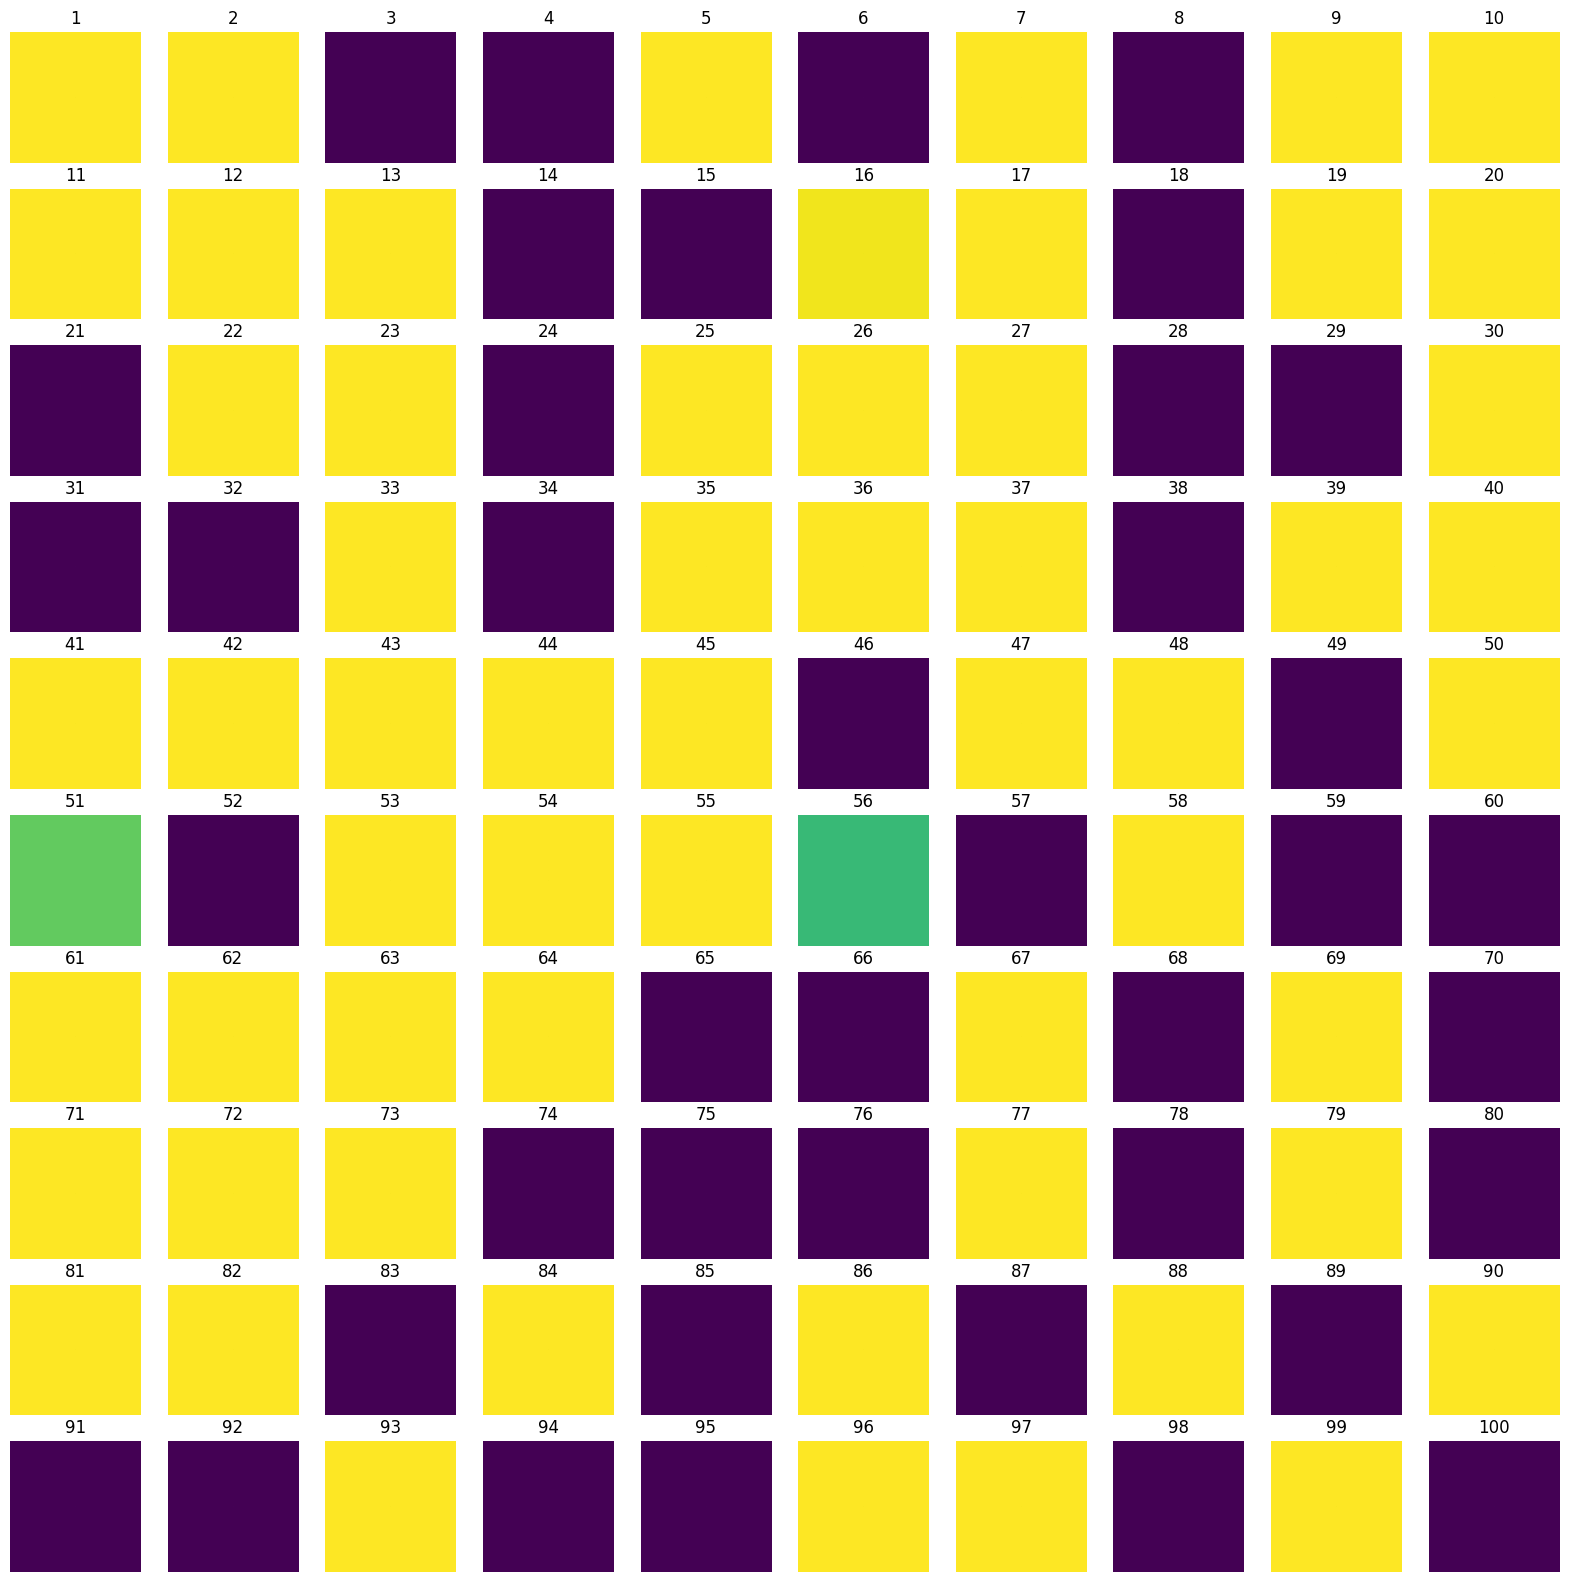

In [111]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i in range(config["hidden_dim"]):
    axs[i // 10, i % 10].imshow(activation_matrix[:, :, i], cmap='viridis')
    axs[i // 10, i % 10].set_title("{}".format(i+1))
    axs[i // 10, i % 10].axis('off')
plt.show()

<Axes: >

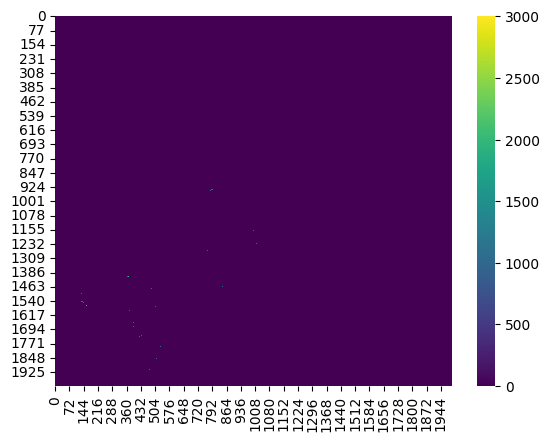

In [131]:
# plt.imshow(activation_matrix[:, :, i], cmap='viridis')
import seaborn as sns
sns.heatmap(count_matrix, cmap='viridis')

In [132]:
print(count_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [133]:
print(sum(count_matrix.flatten()))

500000.0
